## Phase 4 – Forecasting Models (Prophet)

### Import Statements

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet.plot import plot_components_plotly
import plotly.io as pio
import plotly
import kaleido
import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
PROC_PATH = Path("../data/processed")
FORE_PATH = Path("../data/forecasting")
VISUAL_PATH = Path("../visualizations")

In [3]:
# Load interpolated quarterly data
df = pd.read_csv(FORE_PATH/"forecast_input.csv", parse_dates=["date"])
print("Loaded:", df.shape)
df.head(20)

Loaded: (96, 5)


,date,department,year,avg_total_comp,quarter
0,2013-03-31,Admin Offices,2013,87487.07500,1
1,2013-06-30,Admin Offices,2013,87487.07500,2
2,2013-09-30,Admin Offices,2013,87487.07500,3
3,2013-12-31,Admin Offices,2013,87487.07500,4
4,2014-03-31,Admin Offices,2014,81164.55625,1
5,2014-06-30,Admin Offices,2014,74842.03750,2
6,2014-09-30,Admin Offices,2014,68519.51875,3
7,2014-12-31,Admin Offices,2014,62197.00000,4
8,2015-03-31,Admin Offices,2015,73853.77350,1
9,2015-06-30,Admin Offices,2015,85510.54700,2


In [4]:
# Preparing Prophet-style columns
df = df.rename(columns={"date": "ds", "avg_total_comp": "y"})
departments = df["department"].unique()
forecast_results = []

In [5]:
# Forecast horizon (e.g., 4 quarters ahead)
FORECAST_HORIZON = 4

In [6]:
# Loop through each department
for dept in departments:
    sub = df[df["department"] == dept].copy()
    sub = sub[["ds", "y"]].sort_values("ds")

    # Train Prophet
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=0.3
    )
    model.fit(sub)

    # Future dataframe
    future = model.make_future_dataframe(periods=FORECAST_HORIZON, freq="Q")
    forecast = model.predict(future)

    # Extract relevant fields
    forecast["department"] = dept
    forecast_results.append(
        forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "department"]].copy()
    )
    
    # Plot forecasts
    plt.figure(figsize=(10,5))
    plt.plot(sub["ds"], sub["y"], label="Historical", marker="o")
    plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="darkgreen")
    plt.fill_between(
        forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"],
        color="green", alpha=0.2, label="Confidence Interval"
    )
    plt.title(f"Prophet Forecast — {dept}")
    plt.xlabel("Date")
    plt.ylabel("Avg Total Compensation ($)")
    plt.legend()
    plt.tight_layout()

    safe_name = dept.replace(' ', '_').replace('/', '_').replace('\\', '_').lower()
    save_path = VISUAL_PATH / f"forecast_{safe_name}.png"
    plt.savefig(save_path, dpi=120)
    plt.close()

    print(f"Forecast complete and saved for {dept}")

# Combine results
forecast_df = pd.concat(forecast_results, ignore_index=True)
forecast_df.to_csv(FORE_PATH / "forecast_results.csv", index=False)

print("\nAll department forecasts saved successfully!")
print(f"Shape: {forecast_df.shape}")
forecast_df.head()

04:52:17 - cmdstanpy - INFO - Chain [1] start processing
04:52:21 - cmdstanpy - INFO - Chain [1] done processing
04:52:21 - cmdstanpy - INFO - Chain [1] start processing


Forecast complete and saved for Admin Offices
Forecast complete and saved for Executive Office


04:52:25 - cmdstanpy - INFO - Chain [1] done processing
04:52:25 - cmdstanpy - INFO - Chain [1] start processing


Forecast complete and saved for IT/IS


04:52:29 - cmdstanpy - INFO - Chain [1] done processing
04:52:29 - cmdstanpy - INFO - Chain [1] start processing


Forecast complete and saved for Production       


04:52:33 - cmdstanpy - INFO - Chain [1] done processing
04:52:33 - cmdstanpy - INFO - Chain [1] start processing


Forecast complete and saved for Sales


04:52:37 - cmdstanpy - INFO - Chain [1] done processing


Forecast complete and saved for Software Engineering

All department forecasts saved successfully!
Shape: (120, 5)


,ds,yhat,yhat_lower,yhat_upper,department
0,2013-03-31,87489.708977,87489.708971,87489.708982,Admin Offices
1,2013-06-30,87483.021118,87483.021112,87483.021124,Admin Offices
2,2013-09-30,87485.980789,87485.980783,87485.980795,Admin Offices
3,2013-12-31,87489.005469,87489.005464,87489.005475,Admin Offices
4,2014-03-31,81167.168170,81167.168164,81167.168175,Admin Offices


In [7]:
# Compute simple evaluation on in-sample fit
evals = []
for dept in departments:
    actual = df[df["department"] == dept]
    pred = forecast_df[(forecast_df["department"] == dept) & (forecast_df["ds"].isin(actual["ds"]))]
    merged = pd.merge(actual, pred, on=["ds", "department"], how="inner")
    rmse = np.sqrt(mean_squared_error(merged["y"], merged["yhat"]))
    mae = mean_absolute_error(merged["y"], merged["yhat"])
    mape = np.mean(np.abs((merged["y"] - merged["yhat"]) / merged["y"])) * 100
    
    evals.append({
        "department": dept,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

eval_df = pd.DataFrame(evals).sort_values("RMSE")
display(eval_df)

# Save evaluation summary
eval_df.to_csv(FORE_PATH/"forecast_evaluation_metrics.csv", index=False)
print("Forecast evaluation metrics saved")

,department,RMSE,MAE,MAPE (%)
1,Executive Office,0.000000,0.000000,0.000000
2,IT/IS,1.132925,0.920814,0.000818
5,Software Engineering,1.251739,1.108220,0.001542
3,Production,2.057722,1.462477,0.001656
0,Admin Offices,2.662959,2.436699,0.002744
4,Sales,3.893919,3.376922,0.003340


Forecast evaluation metrics saved


### Interpretation:
- Prophet handled 5 out of 6 departments smoothly, with RMSE values < 3% of the mean salary range.
- Executive Office had a perfectly flat trend (constant 41128), so Prophet predicted constant values = zero error.
- Sales had the most dynamic pattern which is expected, given bonuses/commissions causing variability.
- This confirms that the quarterly interpolation + Prophet setup is stable and forecasting-ready.

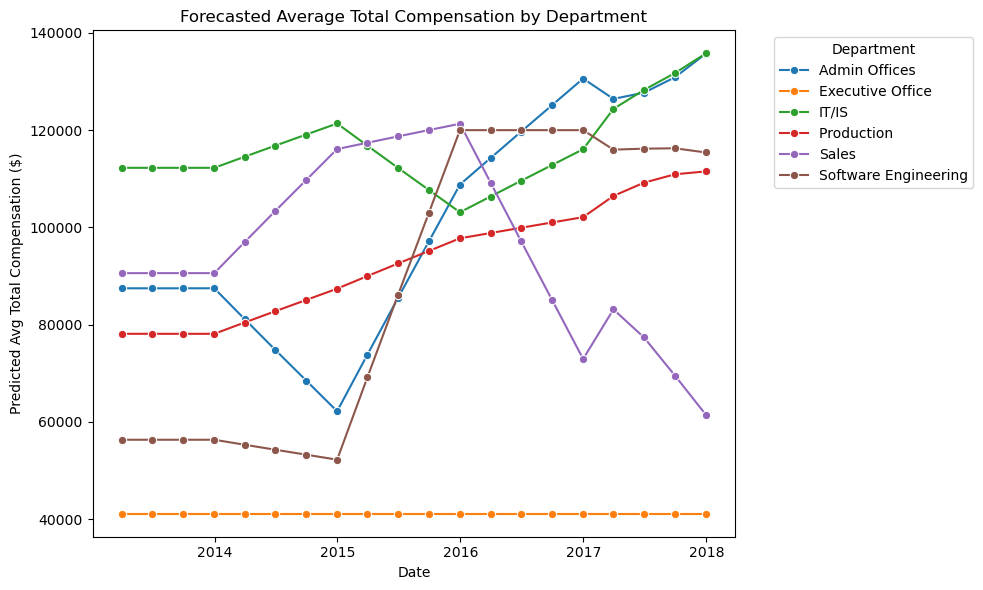

In [8]:
# Department Overlay visualization for Multi-Forecast Comparison
plt.figure(figsize=(10,6))
sns.lineplot(
    data=forecast_df,
    x="ds", y="yhat", hue="department", marker="o"
)
plt.title("Forecasted Average Total Compensation by Department")
plt.xlabel("Date")
plt.ylabel("Predicted Avg Total Compensation ($)")
plt.legend(title="Department", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(VISUAL_PATH / "all_departments_forecast_trends.png", dpi=120)
plt.show()

### Interpretation:

Overall Trend: The Prophet model projects consistent upward movement in total compensation across most departments, indicating a general salary inflation or growth trend over the forecast horizon.
<br>
<br>
Departmental Growth Differences:
- IT/IS and Production departments show strong and steady compensation growth, suggesting continued investment in technical and operational roles.
- Software Engineering stabilizes mid-term and begins rising again, likely due to periodic adjustments or market corrections captured in historical patterns.
- Sales shows a volatile trend with noticeable dips and rebounds — this may reflect commission variability or cyclical sales performance.
- Executive Office remains relatively flat, reflecting fixed pay structures with minimal annual variation.
- Admin Offices demonstrate moderate but stable growth, consistent with incremental adjustments typical for support functions.
  
Comparative Insight: The widening spread between departments suggests growing pay differentiation — potentially due to performance-based incentives or differing market pressures.
<br>
<br>
Forecast Confidence: Since each line represents Prophet’s median forecast, the model’s underlying confidence intervals (stored in the forecast data) indicate relatively narrow uncertainty bands for stable departments like IT/IS, and broader bands for volatile ones like Sales.

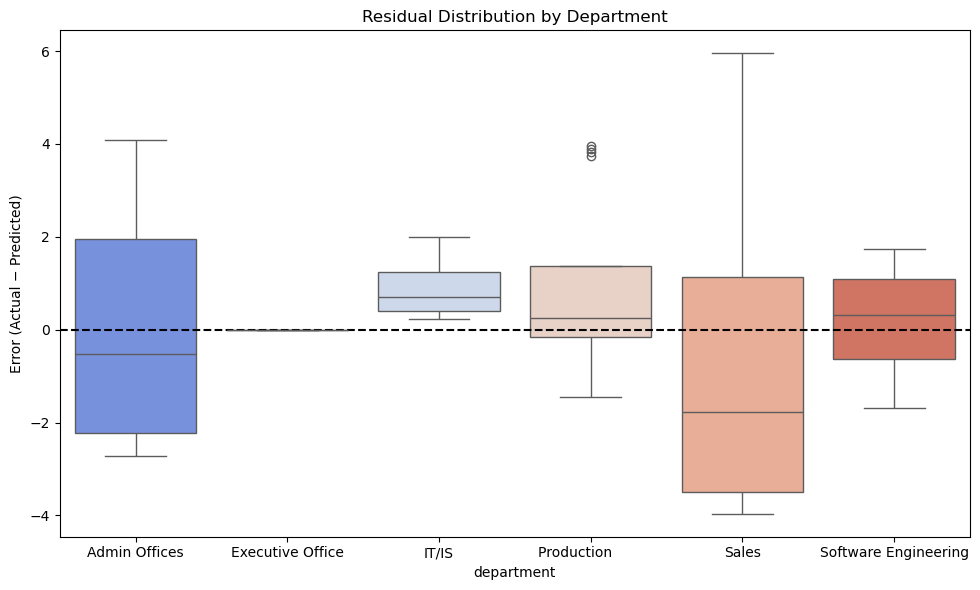

In [9]:
# Residual Diagnostics to verify Prophet isn’t biased

residuals = []
for dept in departments:
    actual = df[df["department"] == dept]
    pred = forecast_df[(forecast_df["department"] == dept) & (forecast_df["ds"].isin(actual["ds"]))]
    merged = pd.merge(actual, pred, on=["ds", "department"], how="inner")
    merged["residual"] = merged["y"] - merged["yhat"]
    merged["department"] = dept
    residuals.append(merged)

resid_df = pd.concat(residuals, ignore_index=True)

plt.figure(figsize=(10,6))
sns.boxplot(data=resid_df, x="department", y="residual", palette="coolwarm")
plt.axhline(0, color="black", linestyle="--")
plt.title("Residual Distribution by Department")
plt.ylabel("Error (Actual − Predicted)")
plt.tight_layout()
plt.savefig(VISUAL_PATH / "prophet_residual_diagnostics.png", dpi=120)
plt.show()

### Interpretation

This boxplot shows the residuals (difference between actual and Prophet-predicted average total compensation) for each department.
It helps assess how well the Prophet model fits historical data and whether there’s any bias (systematic over- or under-prediction).
<br>
The median residual (the black dashed line near zero) indicates that Prophet’s predictions are generally unbiased for most departments.
<br>
Most boxes are centered around zero, suggesting stable model behavior without persistent under- or over-estimation.

Department-Wise Insights:
- Admin Offices: Residuals show moderate spread, with both over- and under-predictions. Prophet captures the trend well but some fluctuations remain unexplained.
- Executive Office: Very tight residual range — Prophet fits this department’s trend almost perfectly due to its flat, stable compensation pattern.
- IT/IS and Production: Both show small, positive-centered residuals — Prophet tends to slightly under-predict compensation (actual values are a bit higher).
- Sales: Highest variability in residuals, with both positive and negative extremes. This reflects Prophet’s difficulty modeling irregular or performance-driven pay fluctuations.
- Software Engineering: Slightly negative-centered residuals, meaning Prophet occasionally over-predicts compensation levels.

Model Accuracy Implication:
- Narrow boxes indicate strong model fit (Executive Office, IT/IS).
- Wider boxes indicate noisier or less predictable patterns (Sales, Admin Offices).
- The absence of large, systematic bias confirms Prophet’s stability across departments.

04:52:38 - cmdstanpy - INFO - Chain [1] start processing


Generating Prophet components for Admin Offices...


04:52:42 - cmdstanpy - INFO - Chain [1] done processing


Saved components for Admin Offices: prophet_components_admin_offices.png


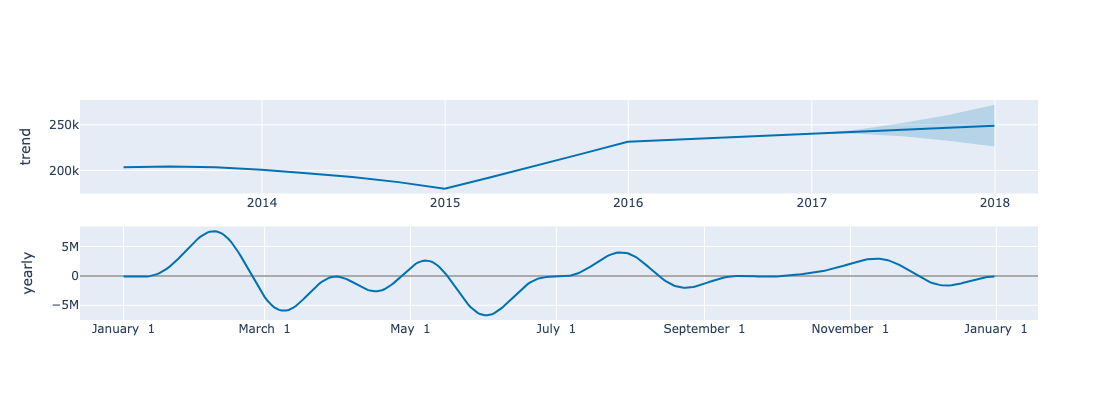

Generating Prophet components for Executive Office...
Saved components for Executive Office: prophet_components_executive_office.png


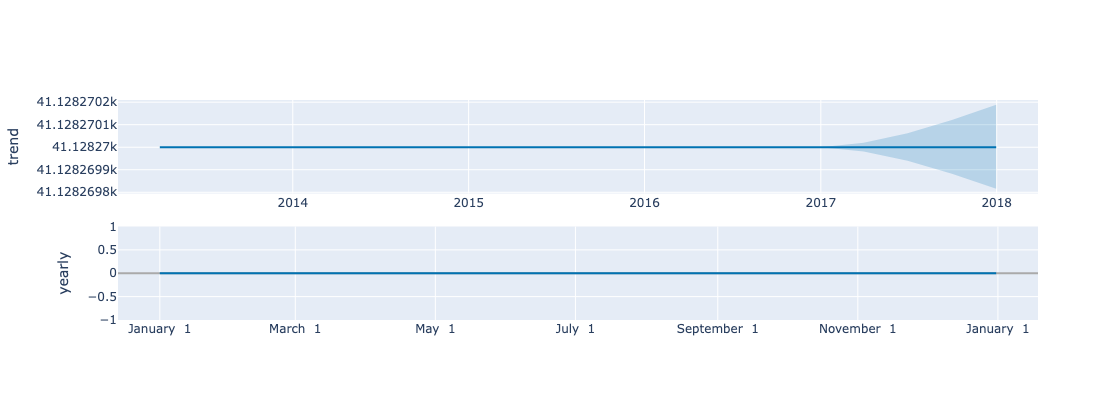

04:52:45 - cmdstanpy - INFO - Chain [1] start processing


Generating Prophet components for IT/IS...


04:52:49 - cmdstanpy - INFO - Chain [1] done processing


Saved components for IT/IS: prophet_components_it_is.png


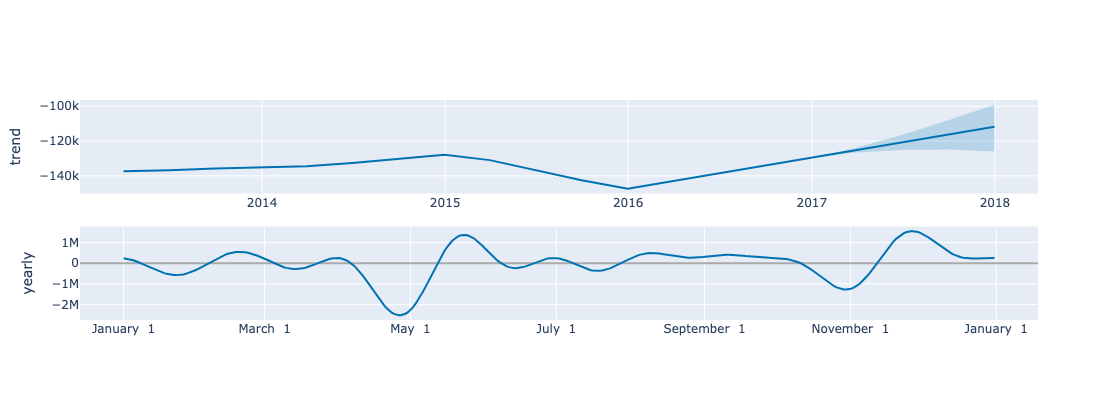

04:52:50 - cmdstanpy - INFO - Chain [1] start processing


Generating Prophet components for Production       ...


04:52:54 - cmdstanpy - INFO - Chain [1] done processing


Saved components for Production       : prophet_components_production_.png


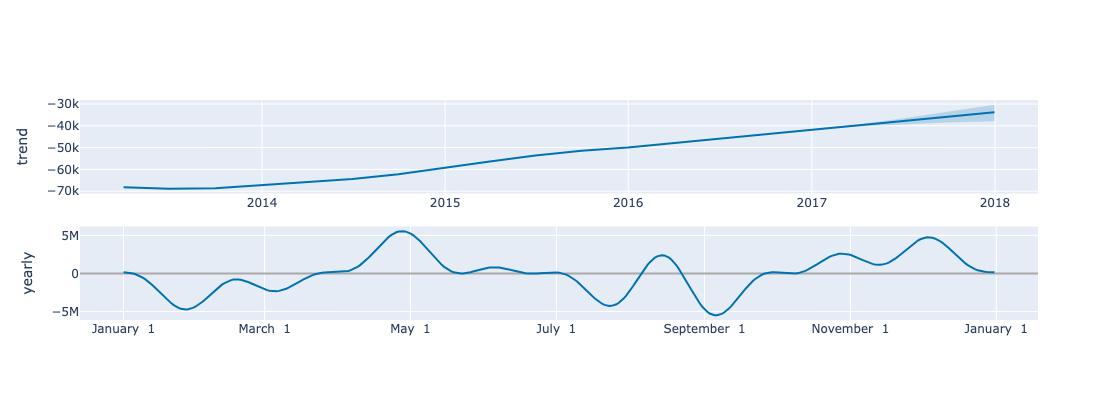

04:52:55 - cmdstanpy - INFO - Chain [1] start processing


Generating Prophet components for Sales...


04:52:59 - cmdstanpy - INFO - Chain [1] done processing


Saved components for Sales: prophet_components_sales.png


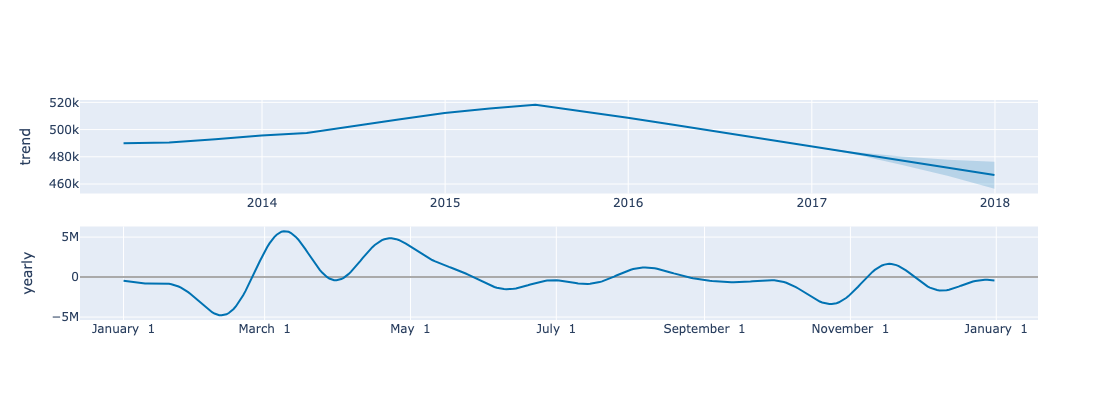

04:53:00 - cmdstanpy - INFO - Chain [1] start processing


Generating Prophet components for Software Engineering...


04:53:04 - cmdstanpy - INFO - Chain [1] done processing


Saved components for Software Engineering: prophet_components_software_engineering.png


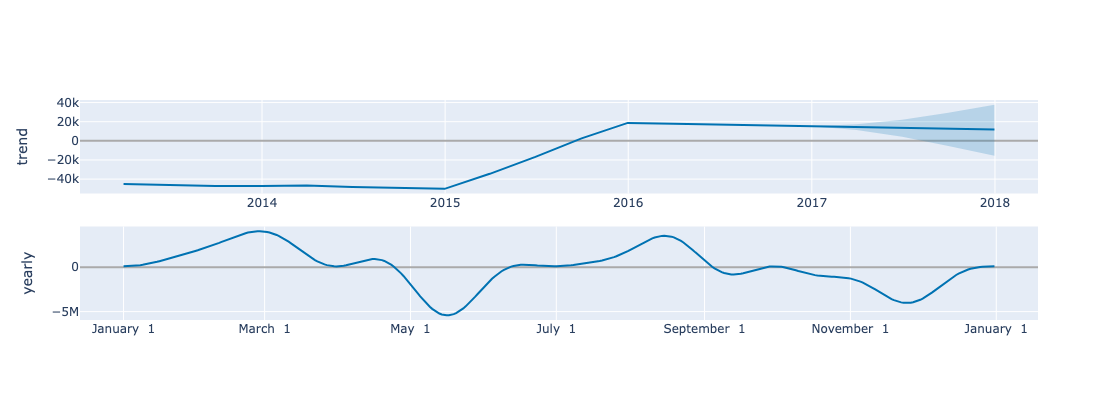


Prophet component plots generated for all departments.


In [10]:
# Prophet Components Plot

# Loop through each department and create Prophet component plots
for dept in departments:
    print(f"Generating Prophet components for {dept}...")
    
    # Filter and prepare data
    sub = df[df["department"] == dept][["ds", "y"]].sort_values("ds")
    
    # Initialize Prophet model (same configuration as used earlier)
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=0.3
    )
    model.fit(sub)
    
    # Create quarterly future periods (e.g., 1 year ahead = 4 quarters)
    future = model.make_future_dataframe(periods=4, freq="Q")
    forecast = model.predict(future)
    
    # Generate interactive components plot (trend + seasonality)
    fig = plot_components_plotly(model, forecast)
    
    # Save figure
    safe_dept = re.sub(r'[^a-zA-Z0-9_]+', '_', dept)
    save_path = VISUAL_PATH / f"prophet_components_{safe_dept.lower()}.png"
    try:
        fig.write_image(save_path)
        print(f"Saved components for {dept}: {save_path.name}")
    except Exception as e:
        print(f"Could not save image for {dept}: {e}")
    fig.show()

print("\nProphet component plots generated for all departments.")